In [1]:
!pip install pytorch-lightning

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import torch
torch.backends.cudnn.deterministic = True
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision

import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.metrics.classification import Accuracy, ConfusionMatrix, F1, ROC, FBeta, Precision, Recall
from pytorch_lightning.metrics import functional as FM

if(torch.cuda.is_available() == True):
    device = torch.device("cuda:0")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Not using GPU")


Using GPU


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from skimage.io import imread

from sklearn.model_selection import train_test_split

import json

In [4]:
annot = json.load(open('/kaggle/input/handgun-detection/export/_annotations.coco.json', 'r'))

In [5]:
img_df = pd.DataFrame.from_dict(annot['images'])
print(img_df.shape)

(2971, 6)


In [6]:
annot_df = pd.DataFrame.from_dict(annot['annotations'])
print(annot_df.shape)

(3432, 7)


In [7]:
data_df = img_df.merge(annot_df, left_on = 'id', right_on = 'image_id')[['file_name', 'bbox']].reset_index(drop = True)
data_df.head()

,file_name,bbox
0,armas (2178).jpg.rf.0095da5f53aa7d641eaeafc9c9...,"[5, 3, 400.40000000000003, 395.2]"
1,armas (289).jpg.rf.00b9b08dd75560324ef6c062f21...,"[209, 106, 176.10666666666668, 147.68]"
2,armas (1757).jpg.rf.007b0a919d789c664d948b38ee...,"[26, 47, 388.96000000000004, 289.865889212828]"
3,armas (1757).jpg.rf.007b0a919d789c664d948b38ee...,"[5, 8, 392.08000000000004, 293.5043731778426]"
4,armas (2531).jpg.rf.008c9a1b51abe57af17789055e...,"[23, 42, 361.40000000000003, 336.26666666666665]"


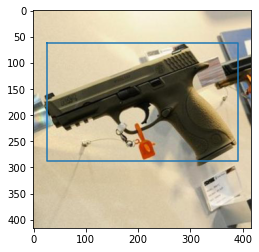

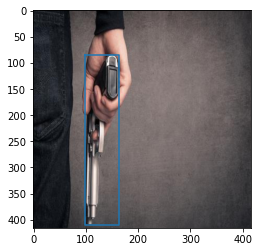

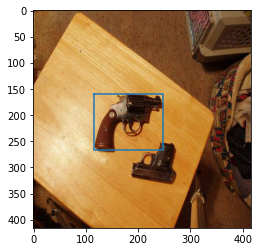

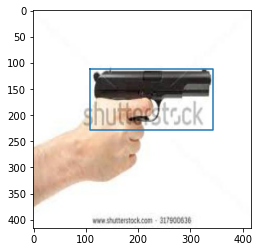

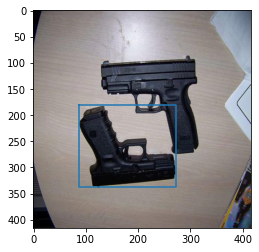

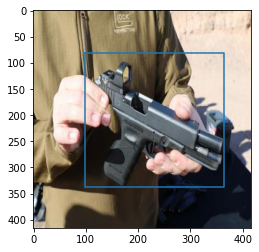

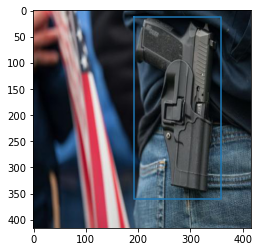

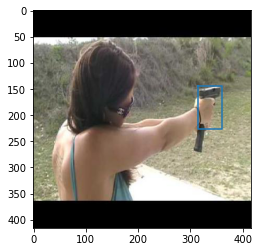

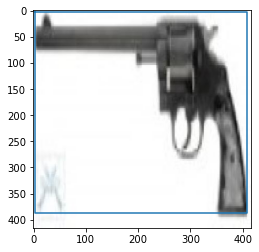

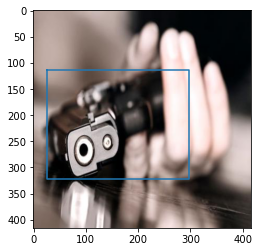

In [8]:
def show_img_bbox(img, raw_bbox):
    bbox = raw_bbox * 416
    bbox_x = [bbox[0], bbox[0] + bbox[2], bbox[0] + bbox[2], bbox[0], bbox[0]]
    bbox_y = [bbox[1], bbox[1], bbox[1] + bbox[3], bbox[1] + bbox[3], bbox[1]]
    plt.imshow(img)
    plt.plot(bbox_x, bbox_y)
    plt.show()

for _ in range(10):
    idx = np.random.choice(np.arange(data_df.shape[0]))

    root_folder = '/kaggle/input/handgun-detection/export/'
    img_filename = data_df.iloc[idx]['file_name']
    img = imread(root_folder + img_filename)
    if(len(img.shape) == 2):
        img = np.expand_dims(img, 2)
    bbox = np.asarray(data_df.iloc[idx]['bbox']) / 416
    
    show_img_bbox(img, bbox)

In [9]:
ORIG_DIM = 416

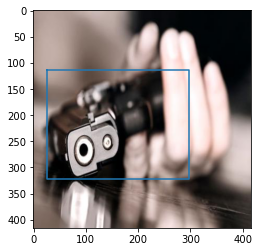

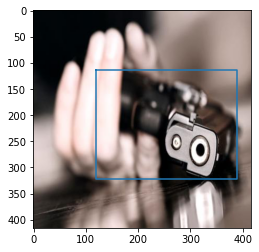

In [10]:
def hflip(img, bbox):
    new_img = img[:, ::-1, :]
    new_bbox = [0, 0, 0, 0]
    new_bbox[0] = 1 - (bbox[0] + bbox[2])
    new_bbox[1] = bbox[1]
    new_bbox[2] = bbox[2]
    new_bbox[3] = bbox[3]
    new_bbox = np.asarray(new_bbox)
    return new_img, new_bbox

show_img_bbox(img, bbox)
show_img_bbox(*hflip(img, bbox))

In [11]:
keep_idx = data_df['file_name'].drop_duplicates().index
data_df = data_df.iloc[keep_idx].reset_index(drop = True)

In [12]:
data_df = pd.concat([data_df, data_df], axis = 0)
print(data_df.shape)
data_df.head()

(5942, 2)


,file_name,bbox
0,armas (2178).jpg.rf.0095da5f53aa7d641eaeafc9c9...,"[5, 3, 400.40000000000003, 395.2]"
1,armas (289).jpg.rf.00b9b08dd75560324ef6c062f21...,"[209, 106, 176.10666666666668, 147.68]"
2,armas (1757).jpg.rf.007b0a919d789c664d948b38ee...,"[26, 47, 388.96000000000004, 289.865889212828]"
3,armas (2531).jpg.rf.008c9a1b51abe57af17789055e...,"[23, 42, 361.40000000000003, 336.26666666666665]"
4,armas (112).jpg.rf.00047bf728076017d2bbd6a3834...,"[118, 63, 218.24, 329.49931600547194]"


In [13]:
data_df = data_df.reset_index(drop = True)
data_df['preprocess'] = pd.Series(np.repeat([0, 1], repeats = 5942 / 2), index = data_df.index)
data_df.head()

,file_name,bbox,preprocess
0,armas (2178).jpg.rf.0095da5f53aa7d641eaeafc9c9...,"[5, 3, 400.40000000000003, 395.2]",0
1,armas (289).jpg.rf.00b9b08dd75560324ef6c062f21...,"[209, 106, 176.10666666666668, 147.68]",0
2,armas (1757).jpg.rf.007b0a919d789c664d948b38ee...,"[26, 47, 388.96000000000004, 289.865889212828]",0
3,armas (2531).jpg.rf.008c9a1b51abe57af17789055e...,"[23, 42, 361.40000000000003, 336.26666666666665]",0
4,armas (112).jpg.rf.00047bf728076017d2bbd6a3834...,"[118, 63, 218.24, 329.49931600547194]",0


In [14]:
data_df = data_df.sample(frac = 1)
train_df = data_df.iloc[:2500 * 2].reset_index(drop = True)
val_df = data_df.iloc[2500 * 2:2700 * 2].reset_index(drop = True)
test_df = data_df.iloc[2700 * 2:].reset_index(drop = True)

In [15]:
BATCH_SIZE = 32
EPOCHS = 100
NUM_WORKERS = 4
ACC_GRAD_BATCHES = 1
PRECISION = 32

In [16]:
root_folder = '/kaggle/input/handgun-detection/export/'
means = np.asarray([0.485, 0.456, 0.406])
stds = np.asarray([0.229, 0.224, 0.225])
def process_X(img_filename):
    img = imread(root_folder + img_filename)
    if(len(img.shape) == 2):
        img = np.expand_dims(img, 2)
    return img

def process_y(bbox):
    targets = np.asarray(bbox, dtype = np.float32) / 416
    return targets

def preprocess(img, bbox, preprocess_type):
    if(preprocess_type == 0):
        return img, bbox
    else:
        return hflip(img, bbox)

class WeaponDataset(Dataset):
    def __init__(self, data_csv, transforms):
        self.data_csv = data_csv
        self.transforms = transforms

    def __len__(self):
        return len(self.data_csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = process_X(self.data_csv.iloc[idx]['file_name'])
        targets = process_y(self.data_csv.iloc[idx]['bbox'])
        image, targets = preprocess(image, targets, self.data_csv.iloc[idx]['preprocess'])
        sample = {'image': image, 'targets': targets}
        sample = self.transforms(sample)
        return sample

class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, targets = sample['image'], sample['targets']
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        image = skimage_transform.resize(image, (new_h, new_w), preserve_range = True)
        targets = skimage_transform.resize(targets, (new_h, new_w), preserve_range = True).round().astype(np.uint8)

        return {'image': image, 'targets': targets}

class Normalize(object):
    def __init__(self, means, stds):
        self.means = means
        self.stds = stds
    
    def __call__(self, sample):
        image, targets = sample['image'], sample['targets']
        #print(image.shape)
        
        image = (image - 0) / (255 - 0)
        image = np.divide(np.subtract(image, self.means), self.stds)
        
        return {'image': image, 'targets': targets}

class ToTensor(object):
    def __call__(self, sample):
        image, targets = sample['image'], sample['targets']

        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image).float(),
                'targets': torch.from_numpy(targets).float()}

img_transforms = torchvision.transforms.Compose([
    #Rescale((224, 224)),
    Normalize(means = means, stds = stds),
    ToTensor()
])

train_dataset = WeaponDataset(train_df, img_transforms)
val_dataset = WeaponDataset(val_df, img_transforms)
test_dataset = WeaponDataset(test_df, img_transforms)

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS)
val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS)
test_dataloader = DataLoader(test_dataset, batch_size = 8, shuffle = False, num_workers = 1)

In [17]:
for batch in test_dataloader:
    print(batch['image'][0, :, :3, :3])
    print(batch['targets'])
    break

tensor([[[2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489]],

        [[2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286]],

        [[2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400]]])
tensor([[0.2692, 0.6250, 0.0967, 0.1763],
        [0.0601, 0.3750, 0.4180, 0.2373],
        [0.2500, 0.2716, 0.5906, 0.5000],
        [0.0168, 0.3894, 0.3759, 0.4031],
        [0.0493, 0.3990, 0.1767, 0.1216],
        [0.0913, 0.3654, 0.2067, 0.0921],
        [0.0144, 0.0986, 0.9833, 0.7372],
        [0.6346, 0.1346, 0.1335, 0.1040]])


In [18]:
class Regr_Model(pl.LightningModule):
    def __init__(self):
        super().__init__()
        pretrained_model = torchvision.models.resnet152(pretrained = True)
        for param in pretrained_model.parameters():
            param.requires_grad = False
        num_ftrs = pretrained_model.fc.in_features
        pretrained_model.fc = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(num_ftrs, 64),
            nn.Dropout(0.25),
            nn.Linear(64, 4),
            nn.Sigmoid()
        )
        self.model = pretrained_model
        
        self.train_mse = pl.metrics.regression.MeanSquaredError()
        self.train_mae = pl.metrics.regression.MeanAbsoluteError()
        self.val_mse = pl.metrics.regression.MeanSquaredError()
        self.val_mae = pl.metrics.regression.MeanAbsoluteError()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch['image'], batch['targets']
        outputs = self.model(x)
        
        loss = nn.MSELoss()(outputs, y)
        
        mse = self.train_mse(outputs, y)
        mae = self.train_mae(outputs, y)
        self.log('train_mse', mse, prog_bar = True)
        self.log('train_mae', mae, prog_bar = True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch['image'], batch['targets']
        outputs = self.model(x)
        mse = self.val_mse(outputs, y)
        mae = self.val_mae(outputs, y)
        self.log('val_mse', mse, prog_bar = True)
        self.log('val_mae', mae, prog_bar = True)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters())
        return optimizer

In [19]:
model = Regr_Model()
tb_logger = pl_loggers.TensorBoardLogger('logs/')

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [20]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import time
start_time = time.time()
early_stop_callback = EarlyStopping(
   monitor='val_mse',
   min_delta=0.01,
   patience=5,
   verbose=False
)
trainer = pl.Trainer(gpus = [0], precision = PRECISION, max_epochs = EPOCHS, accumulate_grad_batches = ACC_GRAD_BATCHES, logger = tb_logger)
trainer.fit(model, train_dataloader = train_dataloader, val_dataloaders = val_dataloader)

stop_time = time.time()
print(f"Time Taken: {(stop_time - start_time):.2f}s")
torch.save(model.state_dict(), './trained_model.pth')

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 58.3 M
1 | train_mse | MeanSquaredError  | 0     
2 | train_mae | MeanAbsoluteError | 0     
3 | val_mse   | MeanSquaredError  | 0     
4 | val_mae   | MeanAbsoluteError | 0     
------------------------------------------------
131 K     Trainable params
58.1 M    Non-trainable params
58.3 M    Total params


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Time Taken: 8676.74s


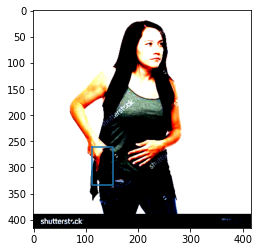

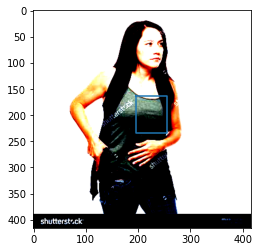

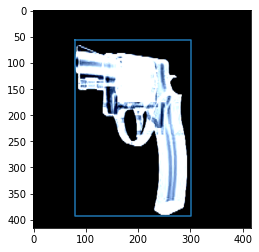

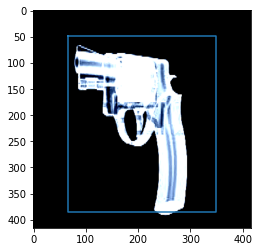

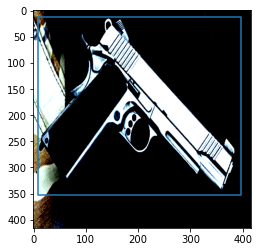

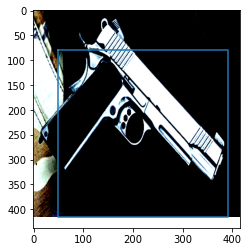

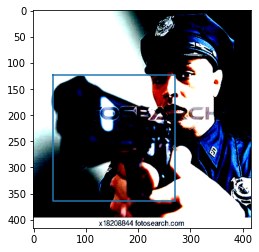

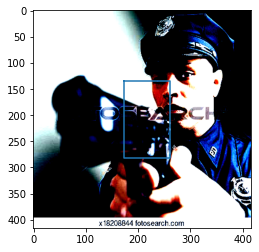

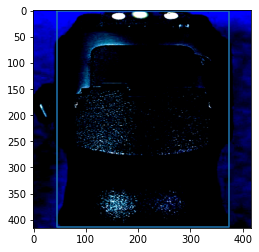

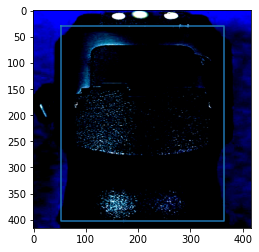

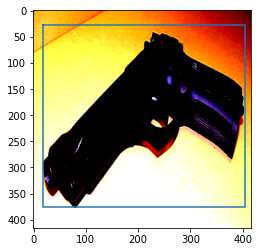

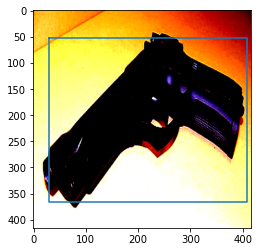

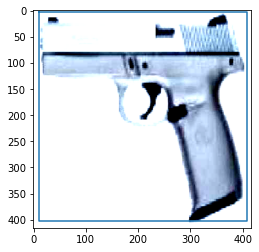

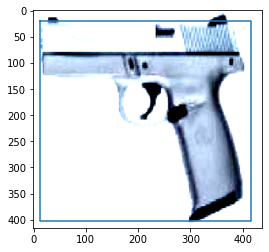

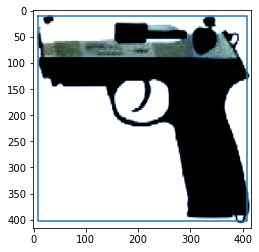

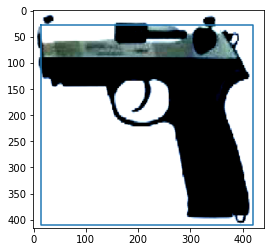

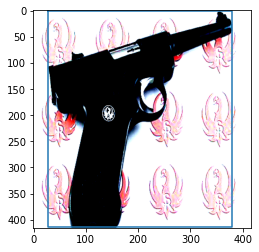

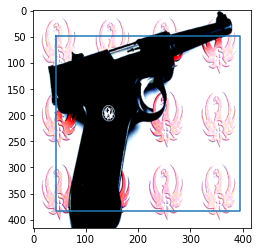

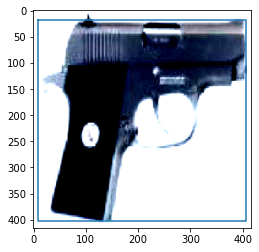

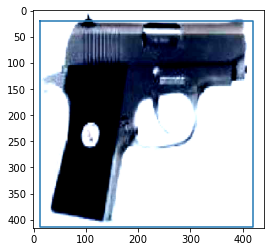

In [21]:
model.freeze()
idx = 0
for batch in test_dataloader:
    img = batch['image'].cpu().numpy()[0, :, :, :].transpose((1, 2, 0))
    bbox = batch['targets'].cpu().numpy()[0, :]
    show_img_bbox(img, bbox)
    output = model(batch['image']).cpu().numpy()[0]
    show_img_bbox(img, output)
    idx += 1
    if(idx == 10):
        break